## Generate HD maps
Identify all genes that are fully within each HD segment.

In [17]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')

file_ascat_summary = get_data_path(['TCGA','ASCATv3_SNP6_hg19'],'summary.ascatv3TCGA.penalty70.hg19.tsv')
file_ascat_homdels = get_local_data_path(['processed','TCGA','ASCAT'], 'homdels.csv')
file_ascat_segment_bounds = get_local_data_path(['processed','TCGA','ASCAT'], 'segment_boundaries.csv')

file_pcawg_samples = get_data_path(['PCAWG'], 'pcawg_donors_tableS1.xlsx')
file_pcawg_icgc_homdels = get_local_data_path(['processed','ICGC'], 'homdels.csv')


# Output
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)
file_tcga_outliers = get_local_data_path(['processed','TCGA','ASCAT'], 'outlier_samples.csv')
file_icgc_outliers = get_local_data_path(['processed','ICGC'], 'outlier_samples.csv')

file_table_s1 = get_local_data_path(['tables'], 'Table_S1_TCGA_HD_matrix.csv')
file_table_s2 = get_local_data_path(['tables'], 'Table_S2_ICGC_HD_matrix.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load genes w/ annotations 

In [2]:
genes = pd.read_csv(file_genes)
passenger_genes = genes[~genes.TSG & ~genes.OG & ~genes.within_driver & ~genes.outside_bounds]
print('N genes:', genes.shape[0], ' --- passenger:', passenger_genes.shape[0])

N genes: 17572  --- passenger: 16898


### TCGA HDs

In [3]:
ascat_summary_all = pd.read_csv(file_ascat_summary, sep='\t')
ascat_summary = ascat_summary_all[(ascat_summary_all['QC']=='Pass')]
print('N TCGA samples:', ascat_summary.patient.nunique())

N TCGA samples: 9966


In [4]:
ascat_summary[:1]

,name,patient,cancer_type,sex,barcodeTumour,barcodeNormal,tumour_mapd,normal_mapd,GC_correction_before,GC_correction_after,...,homdel_segs,homdel_largest,homdel_size,homdel_fraction,LOH,mode_minA,mode_majA,WGD,GI,QC
0,TCGA-02-0001,TCGA-02-0001,GBM,XX,TCGA-02-0001-01C-01D-0182-01,TCGA-02-0001-10A-01D-0182-01,0.2828,0.2716,50bp=0.1387 / 5kb=0.12,50bp=0 / 5kb=0,...,1,351838,351838,0.00012,0.2042,1,1,0,0.6196,Pass


In [5]:
tcga_hds = pd.read_csv(file_ascat_homdels)
tcga_hds = tcga_hds[~tcga_hds['chr'].isin(['X','Y'])].astype({'chr':int}) # Drop X,Y chr segments
tcga_hds = pd.merge(tcga_hds, ascat_summary[['barcodeTumour','cancer_type','ploidy','purity','WGD']])

In [6]:
print('Samples w/ HDs: %d = %.2f%%' % (tcga_hds.patient.nunique(), tcga_hds.patient.nunique()/ascat_summary.shape[0]*100))
print('N HDs:', tcga_hds.shape[0])

Samples w/ HDs: 4252 = 42.67%
N HDs: 11831


In [7]:
tcga_hds[:1]

,name,patient,cancer_type,barcodeTumour,chr,startpos,endpos,del_len,ploidy,purity,WGD
0,TCGA-02-0001,TCGA-02-0001,GBM,TCGA-02-0001-01C-01D-0182-01,9,21907786,22259623,351837,2.3329,0.58,0


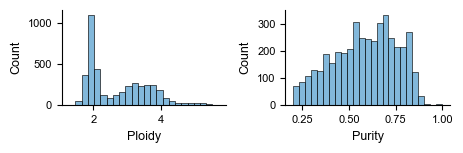

In [8]:
f, ax = plt.subplots(1, 2, figsize=(4.7,1.6))
sns.histplot(tcga_hds.drop_duplicates(subset=['patient']).ploidy, ax=ax[0], color='#58a1cf')
sns.histplot(tcga_hds.drop_duplicates(subset=['patient']).purity, ax=ax[1], color='#58a1cf')
ax[0].set_xlabel('Ploidy'); ax[1].set_xlabel('Purity');
plt.tight_layout()

#### Map genes to segments

In [9]:
tcga_hd_map = util.map_segments_to_genes(tcga_hds, genes[~genes.outside_bounds], overlap_func=util.map_segment_full)

In [10]:
tcga_hd_map_partial = util.map_segments_to_genes(tcga_hds, genes[~genes.outside_bounds], overlap_func=util.map_segment_partial)

#### HDs per sample

In [11]:
tcga_del_per_sample = util.count_dels_per_sample(tcga_hd_map, 'patient')
tcga_del_per_sample = pd.merge(tcga_del_per_sample, ascat_summary[['cancer_type','patient','WGD','ploidy']])
print('N samples w/ 1+ deleted gene:', tcga_del_per_sample[tcga_del_per_sample.n_genes>0].shape[0])

N samples w/ 1+ deleted gene: 2795


#### Detecting outliers --- samples with extreme genomic instability

In [12]:
print('Max deleted genes per sample:', tcga_del_per_sample.n_genes.max())
print('Median genes deleted per sample:', tcga_del_per_sample.n_genes.median())
print('Mean deleted genes per sample:', tcga_del_per_sample.n_genes.mean())

Max deleted genes per sample: 289
Median genes deleted per sample: 2.0
Mean deleted genes per sample: 7.963546566321731


In [13]:
tcga_outliers = tcga_del_per_sample[(tcga_del_per_sample.n_genes>100)]['patient'].reset_index(drop=True)
print('N w/ >100 HD genes:', tcga_outliers.shape[0])
tcga_outliers.to_csv(file_tcga_outliers, index=0)

N w/ >100 HD genes: 15


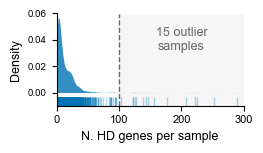

In [14]:
f, ax = plt.subplots(1, 1, figsize=(2.7, 1.6))
c = gp.get_color('blue')
df = tcga_del_per_sample[tcga_del_per_sample.n_genes>0]
sns.kdeplot(df.n_genes.clip(upper=300), ax=ax, color=c, fill=True, lw=0, alpha=.8)
sns.rugplot(df.n_genes, ax=ax, color=c, height=0.1, alpha=.3)
ax.axvline(100, color='#666', linestyle='--'); ax.axvspan(100,300, color='#f6f6f6', zorder=-10)
ax.set_ylim([-0.01,0.06]); ax.set_xlim([0,300]);
gp.set_axis_props(ax, xlabel='N. HD genes per sample', show_yticklabels=True, ytick_fontsize=7); plt.tight_layout()
ax.text(200, 0.04, "15 outlier\nsamples", ha='center', va='center', color='#666')
plt.savefig('../figures/tcga_samples.png', bbox_inches='tight', dpi=500)

#### Save filtered HD maps

In [15]:
tcga_hd_map_final = tcga_hd_map[~tcga_hd_map.patient.isin(tcga_outliers) & (tcga_hd_map.del_len>0)].reset_index(drop=True)
print('N HDs:', tcga_hd_map_final.shape[0])
util.serialize_map(tcga_hd_map_final, folder_hd_maps("tcga_hd_map.csv"))

N HDs: 11641


In [16]:
tcga_hd_map_partial_final = tcga_hd_map_partial[~tcga_hd_map_partial.patient.isin(tcga_outliers) & 
                                                (tcga_hd_map_partial.del_len>0)].reset_index(drop=True)
print('N HDs:', tcga_hd_map_partial_final.shape[0])
util.serialize_map(tcga_hd_map_partial_final, folder_hd_maps("tcga_part_hd_map.csv"))

N HDs: 11641


#### Other graphs

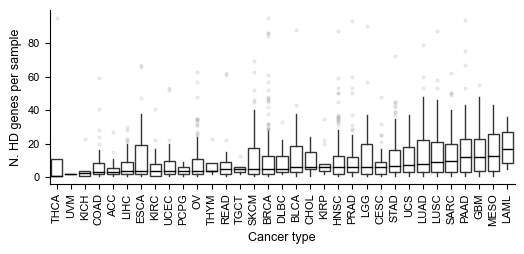

In [17]:
f, ax = plt.subplots(1, 1, figsize=(6, 2.3))
df = tcga_del_per_sample[(tcga_del_per_sample.n_genes>0) & (tcga_del_per_sample.n_genes<=100)]
med = df.groupby('cancer_type').n_genes.median().sort_values()
sns.boxplot(data=df.assign(cancer_type=pd.Categorical(df.cancer_type, categories=med.index)), 
            x='cancer_type', y='n_genes', ax=ax, color='w', **gp.get_boxplot_props())
plt.xticks(rotation=90); ax.set_xlabel('Cancer type'); _=ax.set_ylabel('N. HD genes per sample')

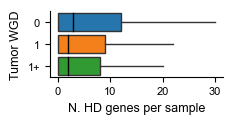

In [18]:
# More deletions for metastatic samples?
f, ax = plt.subplots(1, 1, figsize=(2.4, 1.3))
sns.boxplot(data=tcga_del_per_sample, y='WGD', x='n_genes', showfliers=False, **gp.get_boxplot_props()); 
ax.set_ylabel('Tumor WGD'), ax.set_xlabel('N. HD genes per sample'); plt.tight_layout()

### ICGC (PCAWG) HDs

In [18]:
sample_list = pd.read_excel(file_pcawg_samples, engine='openpyxl', skiprows=2)
icgc_samples = sample_list[sample_list.tcga_donor_uuid.isna()].reset_index(drop=True)
print('N PCAWG ICGC samples:', icgc_samples.shape[0])
assert(icgc_samples[icgc_samples.duplicated(subset=['icgc_donor_id'], keep=False)].shape[0]==0)
icgc_samples[:1]

N PCAWG ICGC samples: 1782


,tumour_specimen_aliquot_id,normal_specimen_aliquot_id,icgc_donor_id,icgc_sample_id,icgc_specimen_id,dcc_specimen_type,project_code,gender,age,organ_system,...,specimen_donor_treatment_type,donor_wgs_included_excluded,specimen_library_strategy,gain_count,loss_count,hd_count,wgd,all.SNVs,all.MNVs,all.Indels
0,0009b464-b376-4fbc-8a56-da538269a02f,5ef2ed4d-464e-4a51-95e0-401d9ae7be86,DO46416,SA505245,SP101724,Recurrent tumour - other,OV-AU,female,54.0,OVARY,...,other therapy,Included,WGS,288,349,0,1,15273,225,670


In [19]:
icgc_hds = pd.read_csv(file_pcawg_icgc_homdels) # All segments with CN=0
icgc_hds = icgc_hds[~icgc_hds['chr'].isin(['X','Y'])].astype({'chr':int}) # Drop X,Y chr segments
icgc_hds = pd.merge(icgc_samples[['tumour_specimen_aliquot_id',
                                  'icgc_donor_id']].rename(columns={'tumour_specimen_aliquot_id':'samplename'}), 
                    icgc_hds).drop(columns=['samplename'])
print('N samples w/ HDs: %d' % icgc_hds['icgc_donor_id'].nunique())
print('N HDs:', icgc_hds.shape[0])
icgc_hds[:1]

N samples w/ HDs: 844
N HDs: 3545


,icgc_donor_id,chr,startpos,endpos,total_cn,del_len
0,DO45049,10,114188018,114730699,0.0,542681


#### Map genes to segments

In [20]:
icgc_hd_map = util.map_segments_to_genes(icgc_hds, genes, overlap_func=util.map_segment_full)

In [21]:
icgc_hd_map_partial = util.map_segments_to_genes(icgc_hds, genes, overlap_func=util.map_segment_partial)

#### HDs per sample

In [22]:
icgc_del_per_sample = util.count_dels_per_sample(icgc_hd_map, 'icgc_donor_id')
print('N samples w/ 1+ deleted gene:', icgc_del_per_sample[icgc_del_per_sample.n_genes>0].shape[0])

N samples w/ 1+ deleted gene: 533


#### Detecting outliers --- samples with extreme genomic instability

In [23]:
print('Max deleted genes per sample:', icgc_del_per_sample.n_genes.max())
print('Median genes deleted per sample:', icgc_del_per_sample.n_genes.median())
print('Mean deleted genes per sample:', icgc_del_per_sample.n_genes.mean())

Max deleted genes per sample: 1201
Median genes deleted per sample: 2.0
Mean deleted genes per sample: 10.056872037914692


In [24]:
icgc_outliers = icgc_del_per_sample[(icgc_del_per_sample.n_genes>100)]['icgc_donor_id'].reset_index(drop=True)
print('N w/ >100 HD genes:', icgc_outliers.shape[0])
icgc_outliers.to_csv(file_icgc_outliers, index=0)

N w/ >100 HD genes: 8


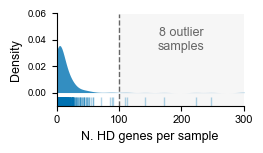

In [25]:
f, ax = plt.subplots(1, 1, figsize=(2.7, 1.6))
c = gp.get_color('blue')
df = icgc_del_per_sample[icgc_del_per_sample.n_genes>0]
sns.kdeplot(df.n_genes.clip(upper=300), ax=ax, color=c, fill=True, lw=0, alpha=.8)
sns.rugplot(df.n_genes, ax=ax, color=c, height=0.1, alpha=.3)
ax.axvline(100, color='#666', linestyle='--'); ax.axvspan(100,300, color='#f6f6f6', zorder=-10)
ax.set_ylim([-0.01,0.06]); ax.set_xlim([0,300]);
gp.set_axis_props(ax, xlabel='N. HD genes per sample', show_yticklabels=True, ytick_fontsize=7); plt.tight_layout()
ax.text(200, 0.04, "8 outlier\nsamples", ha='center', va='center', color='#666')
plt.savefig('../figures/icgc_samples.png', bbox_inches='tight', dpi=500)

#### Save filtered HD maps

In [26]:
icgc_hd_map_final = icgc_hd_map[~icgc_hd_map.icgc_donor_id.isin(icgc_outliers) & (icgc_hd_map.del_len>0)].reset_index(drop=True)
print('N HDs:', icgc_hd_map_final.shape[0])
util.serialize_map(icgc_hd_map_final, folder_hd_maps("icgc_hd_map.csv"))

N HDs: 3487


### Generate binary HD matrix: samples x genes

In [27]:
def generate_hd_mat(hd_map, sample_col, all_samples):
    df = hd_map[[sample_col,'genes']].explode('genes').dropna().assign(val=1).reset_index(drop=True)
    df = pd.merge(df.rename(columns={'genes':'entrez_id'}), genes[['entrez_id','symbol']])
    hd_mat = df.pivot(index=sample_col, columns='symbol', values='val').fillna(0).astype(int)
    print(hd_mat.shape)
    # Add empty rows and columns for genes / samples without any HDs
    hd_mat = hd_mat.reindex(index=all_samples, columns=genes.symbol, fill_value=0)
    print(hd_mat.shape)
    return hd_mat

#### TCGA

In [28]:
tcga_hd_mat = generate_hd_mat(tcga_hd_map_final, sample_col='patient',
                              all_samples=ascat_summary[~ascat_summary.patient.isin(tcga_outliers)]['patient'])

(2780, 6012)
(9951, 17572)


In [29]:
assert((tcga_hd_mat.sum()>0).sum()==6012)
assert((tcga_hd_mat.sum(axis=1)>0).sum()==2780)

In [30]:
tcga_hd_mat[:1]

symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
tcga_hd_mat.to_csv(file_table_s1)

#### ICGC

In [33]:
icgc_hd_mat = generate_hd_mat(icgc_hd_map_final, sample_col='icgc_donor_id',
                              all_samples=icgc_samples[~icgc_samples.icgc_donor_id.isin(icgc_outliers)]['icgc_donor_id'])

(525, 2092)
(1774, 17572)


In [34]:
assert((icgc_hd_mat.sum()>0).sum()==2092)
assert((icgc_hd_mat.sum(axis=1)>0).sum()==525)

In [35]:
icgc_hd_mat[:1]

symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
icgc_donor_id,,,,,,,,,,,,,,,,,,,,,
DO46416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
icgc_hd_mat.to_csv(file_table_s2)